In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Math, Latex

#print(plt.style.available)
plt.style.use('ggplot')

#print(matplotlib.rcParams['figure.figsize'])
matplotlib.rcParams['figure.figsize'] = [12., 8.]

def padded_plot(plotter=plt, x_min=-10, x_max=10, y_min=-.02, y_max=.02):
    def padded_plot_decorator(func, **kwargs):
        def wrapper(*args, **kwargs):
            func(*args, **kwargs)
            x0, x1, y0, y1 = plotter.axis()
            plotter.axis((x0 + x_min, x1 + x_max, y0 + y_min, y1 + y_max))
        return wrapper
    return padded_plot_decorator

## Übung 5

### 5.1 Hashfunktionen und DHT

#### 5.1.1 Hashfunktion djb2

Es soll die Hashfunktion `djb2` implementiert werden. Die dafür zu verwendende Funktion ist

$X_i := (a * X_{i-1}) + c_i$  (mod $M$)

mit den Parametern $X_0 = 5381$, $a = 33$ und $M = 2^{32}$.

In [2]:
def djb2(value, M=np.power(2, 32)):
    x_i = 5381
    for i in range(len(value)):
        char = value[i]
        x_i = ((33 * x_i) + ord(char)) % M
    return x_i

print('djb2 of "Hallo Welt": %d' % djb2('Hallo Welt'))

djb2 of "Hallo Welt": 2793804081


#### 5.1.2 Test Hash

In [3]:
import matplotlib.mlab as mlab
from itertools import groupby

dht = {
    16: [],
    32: []
}

# hashes erstellen
with open('exercise5_names.txt', mode='r') as names:
    for name in names:
        name = name.strip()
        dht[16].append((djb2(name, np.power(2, 16)), name))
        dht[32].append((djb2(name), name))

# ausgabe der kollisionen
def group_hashes(dht):
    dht = sorted(dht, key=lambda k: k[0])
    result = []
    for k, g in groupby(dht, key=lambda k: k[0]):
        names = list(g)
        result.append((k, [n[1] for n in names]))
    return result

dht = {
    16: group_hashes(dht[16]),
    32: group_hashes(dht[32])
}

def count_hash_dups(dht):
    count = 0
    for _hash, names in dht:
        if len(names) > 1:
            count += 1
    return count

print('Kollisionen:')
display(Math(r'M = 2^{16}: %d' % count_hash_dups(dht[16])))
display(Math(r'M = 2^{32}: %d' % count_hash_dups(dht[32])))

heads = 10
print('Ersten %d Hashes und Namen in dht[16]' % heads)
for i in range(heads):
    print(dht[16][i])

Kollisionen:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ersten 10 Hashes und Namen in dht[16]
(6, ['TWILA'])
(13, ['AUDIE', 'LORRI'])
(17, ['ULRIKE'])
(20, ['ERICKA'])
(33, ['ALAN'])
(53, ['ALBA'])
(57, ['ALETHEA'])
(85, ['TAMIE'])
(91, ['MAMMIE'])
(94, ['ALEXANDRIA'])


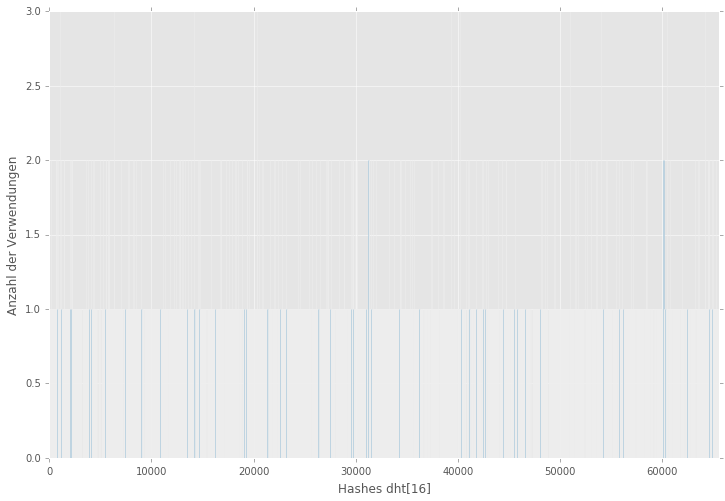

In [4]:
plt.bar([x[0] for x in dht[16]], [len(y[1]) for y in dht[16]], width=1)
plt.xlim(0, np.power(2, 16))
plt.xlabel('Hashes dht[16]')
plt.ylabel('Anzahl der Verwendungen')
plt.show()

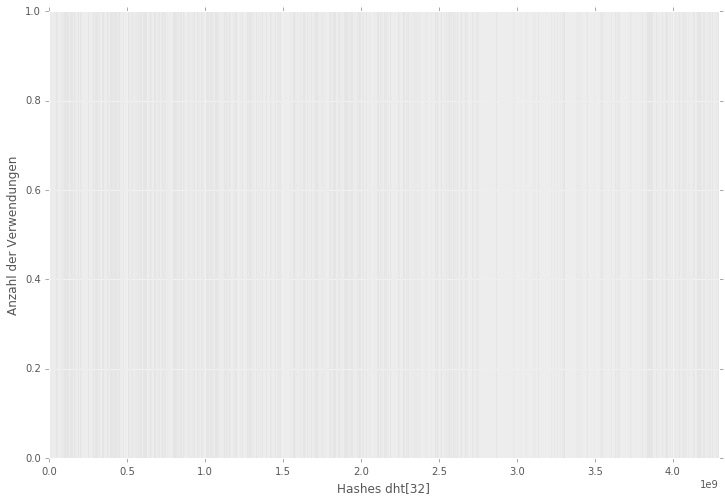

In [5]:
plt.bar([x[0] for x in dht[32]], [len(y[1]) for y in dht[32]], width=.1)
plt.xlim(0, np.power(2, 32))
plt.xlabel('Hashes dht[32]')
plt.ylabel('Anzahl der Verwendungen')
plt.show()

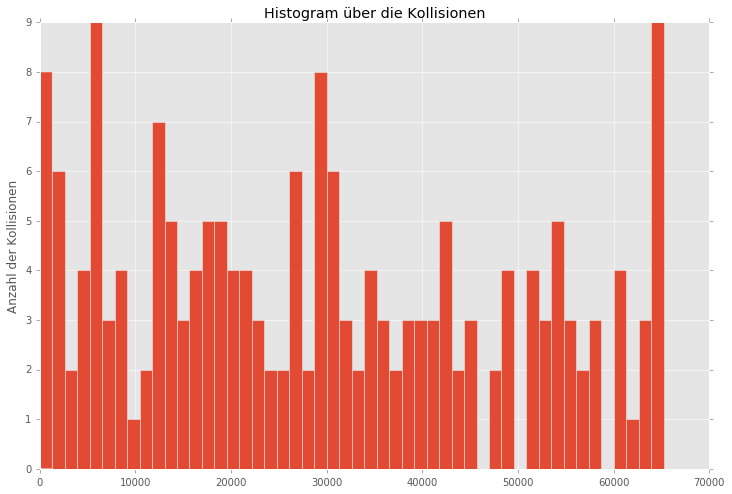

In [6]:
collisions = [x[0] for x in dht[16] if len(x[1]) > 1]
plt.title('Histogram über die Kollisionen')
plt.ylabel('Anzahl der Kollisionen')
plt.hist(collisions, bins=50)
plt.show()

#### 5.1.3 Distanzen $\Delta X$

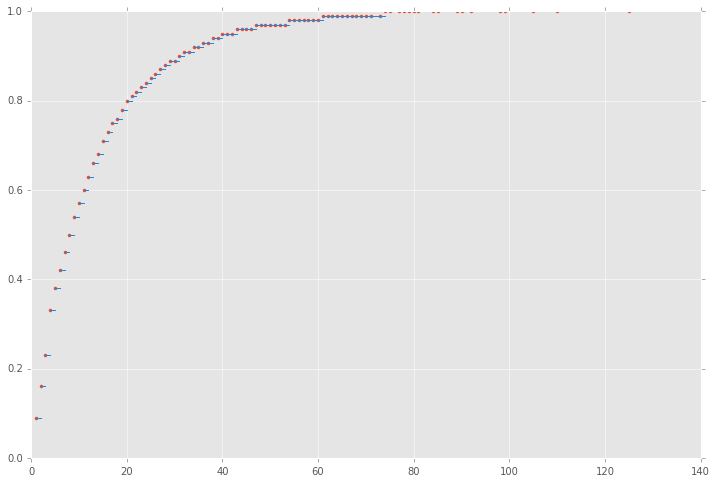

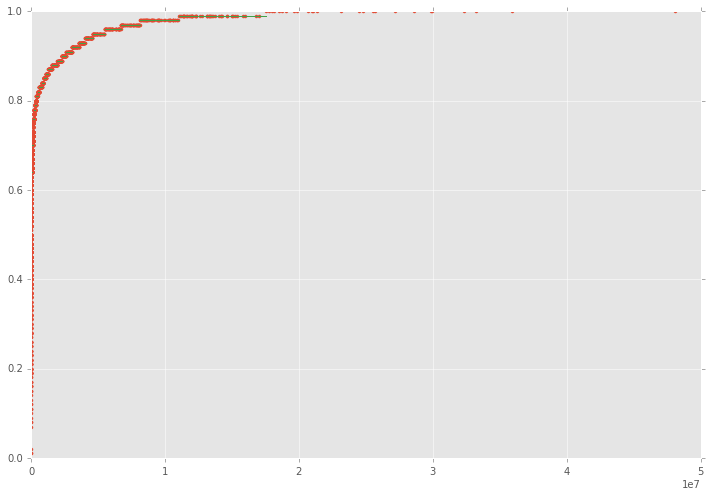

In [7]:
def ecdf(values):
    
    values = sorted(values)

    unique_values = sorted(list(set(values)))

    cumsum_values = []
    for u in unique_values:
        cumsum_values.append((u, len([1 for _ in values if _ <= u])))

    y = np.round([c / len(values) for t, c in cumsum_values], decimals=2)
    
    return unique_values, y
    
def plot_distance(x, y, color='#1e88e5'):
    plt.plot(x, y, linestyle=' ', marker='.')

    for i in range(len(x)):
        x_0 = x[i]
        x_1 = x[i + 1] if i < len(x) - 1 else x[i] + 1
        plt.plot([x_0, x_1], [y[i], y[i]], color=color, linestyle='-')
    

# normalerweise müsste für np.diff noch ein sorted hinzugefügt
# werden. das ist aber durch die vorige gruppierung
# der dht bereits geschehen
hash_diffs = {
    16: np.diff([i[0] for i in dht[16]]),
    32: np.diff([i[0] for i in dht[32]]),
}
x, y = ecdf(hash_diffs[16])
plot_distance(x, y)
plt.show()

x, y = ecdf(hash_diffs[32])
plot_distance(x, y, color='#43a047')
plt.show()

#### 5.1.4 Curve Fit $\Delta D$

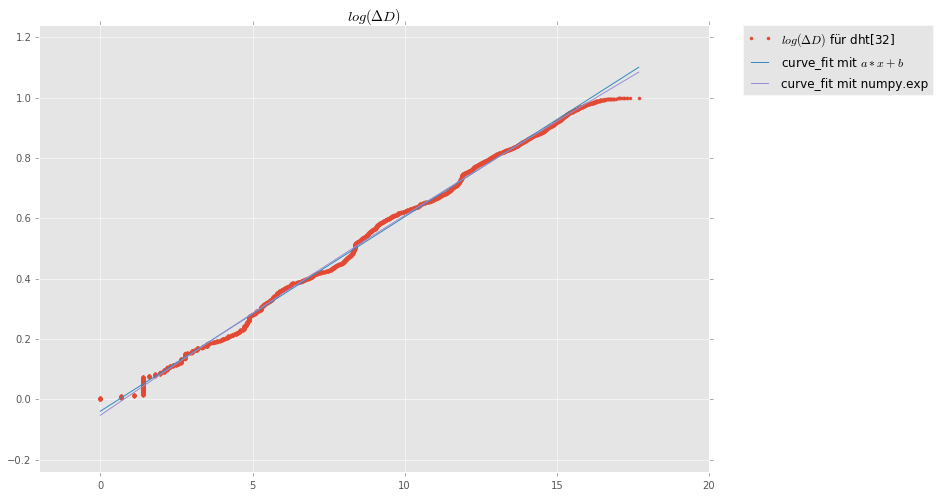

In [8]:
from scipy.optimize import curve_fit

log_dd = {
    #16: np.log(sorted(hash_diffs[16])),
    32: np.log(sorted(hash_diffs[32]))
}

@padded_plot(x_min=-1, x_max=1)
def plot_fit(func, label, x, y):
    """Fuehrt ein curve fit mit gegebener Funktion und
    x und y Werten aus. Das Ergebnis wird mit dem 
    gegebenen Label geplottet.
    """
    popt, pcov = curve_fit(func, x, y)
    y_i = [func(_x, *popt) for _x in x]
    plt.plot(x, y_i, label=label)
    
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

for l in log_dd:
    y = np.arange(len(log_dd[l])) / len(log_dd[l])
    plt.plot(log_dd[l], y, '.', label='$log(\Delta D)$ für dht[%d]' % l)
    
    # curve fit mit linearem polynom
    plot_fit(lambda x, a, b: a + b*x, 'curve_fit mit $a * x + b$', log_dd[l], y)
    
    # curve fit mit exponentialfunktion
    plot_fit(exp_func, 'curve_fit mit numpy.exp', log_dd[l], y)
    
plt.title('$log(\Delta D)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

#### 5.1.5 Peers

ID: 427182379    Objekte: 271814143
ID: 698996522    Objekte: 411897769
ID: 1110894291   Objekte: 525050630
ID: 1635944921   Objekte: 190879379
ID: 1826824300   Objekte: 281957695
ID: 2108781995   Objekte: 74329558
ID: 2183111553   Objekte: 150850384
ID: 2333961937   Objekte: 264954804
ID: 2598916741   Objekte: 1048431418
ID: 3647348159   Objekte: 1074801515


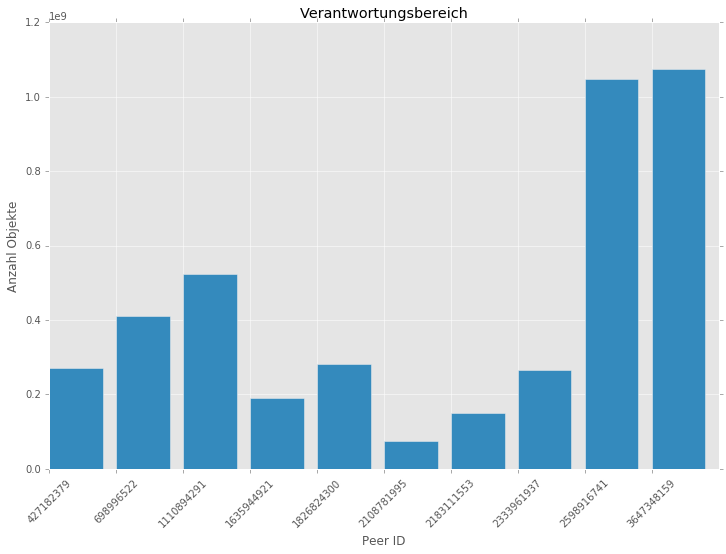

In [9]:
import random

# generierung von zufaelligen knoten
num_peers = 10
peers = []
for i in range(num_peers):
    peers.append({'id': random.randint(0, np.power(2, 32))})
peers = sorted(peers, key=lambda p: p['id'])

# bestimmung des verantwortungsbereichs fuer alle knoten
last_peer = None
for i in range(len(peers)):
    current_peer = peers[i]
    if last_peer is not None:
        # setzen des verantwortungsbereichs fuer den vorigen knoten
        peers[i - 1]['objects'] = current_peer['id'] - last_peer['id']
    last_peer = current_peer
# der verantwortungsbereich des letzten knotens liegt von
# seiner id bis zum ende des gesamten bereichs und
# von 0 bis zum ersten knoten - 1
peers[-1]['objects'] = (np.power(2, 32) - last_peer['id']) + (peers[0]['id'] - 1)

for peer in peers:
    print('ID: {:<12d} Objekte: {:d}'.format(peer['id'], peer['objects']))

plt.bar([i for i in range(num_peers)], 
        [peer['objects'] for peer in peers])

plt.xticks([i for i in range(num_peers)],
           [peer['id'] for peer in peers], 
           rotation=45)
plt.title('Verantwortungsbereich')
plt.xlabel('Peer ID')
plt.ylabel('Anzahl Objekte')
plt.show()

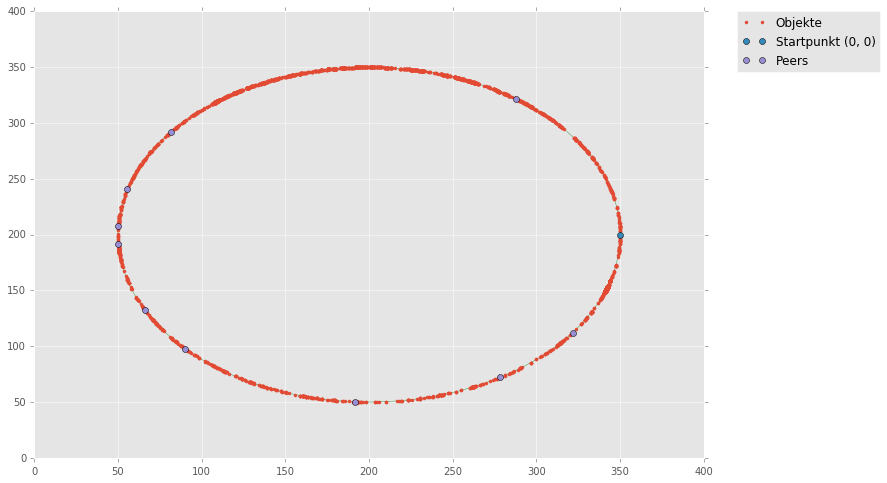

In [10]:
x_min = 0
x_max = 400
y_min = 0
y_max = 400

fig, ax = plt.subplots()
plt.axis([x_min, x_max, y_min, y_max])

circle_x = (x_max - x_min) / 2.
circle_y = (y_max - y_min) / 2.

radius = 150

# zeichnen eines kreises der den gesamten raum 0 <= n <= 2^32 angibt
circ = plt.Circle((circle_x, circle_y), radius=radius, color='#43a047', fill=False)
ax.add_patch(circ)

def coords(hashes, N=np.power(2, 32), radius = 10, x_trans=0, y_trans=0):
    """Liefert die Polarkoordinaten der gegebenen Hashes auf dem zuvor
    berechneten Kreis. Das Resultat ist ein zwei dimensionales Array
    mit den X- und Y-Koordinaten ([[x1, x2...], [y1, y2...]])
    """
    result = [[], []]
    for h in hashes:
        # winkel auf dem kreis ausgehend vom startpunkt im uhrzeigersinn (-)
        angle = -h / N * 360

        # bogenmaß des winkels bestimmen
        rad_angle = angle / 180. * np.pi

        # x = cos(a) * radius 
        # y = sin(a) * radius
        # verschiebung, so dass die koordinaten des kreises passen
        x = np.cos(rad_angle) * radius + x_trans
        y = np.sin(rad_angle) * radius + y_trans
        result[0].append(x)
        result[1].append(y)
    return result

# plotten der objekte
obj_coords = coords([obj[0] for obj in dht[32]], radius=radius, x_trans=200, y_trans=200)
plt.plot(obj_coords[0], obj_coords[1], '.', label='Objekte')

# startpunkt des rings
plt.plot(350, 200, 'o', label='Startpunkt (0, 0)')

# plotten der peers
peer_coords = coords([peer['id'] for peer in peers], radius=radius, x_trans=200, y_trans=200)
plt.plot(peer_coords[0], peer_coords[1], 'o', label='Peers')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### 5.1.6 Wahrscheinlichkeit desselben Hashes

[Hash Collision Probabilities](http://preshing.com/20110504/hash-collision-probabilities/)

Im Artikel wird zunächst der umgekehrte Weg gegangen. Wie hoch ist die Wahrscheinlichkeit, dass $k$ generierte Werte einzigartig sind.

$\dfrac{N - 1}{N}$ ist die Wahrscheinlichkeit, dass zwei Werte denselben Hash besitzen. Daraus folgt:

$\dfrac{N - 1}{N} * \dfrac{N - 2}{N} * ... * \dfrac{N - (k - 2)}{N}* \dfrac{N - (k - 1)}{N} = P(k)$

ist die Wahrscheinlichkeit, dass $k$ erzeugte Hashes einzigartig sind.

Die Wahrscheinlichkeit, dass eine Kollision auftritt ist das Komplement dieser Funktion, also $1 - P(k)$. Diese Vorschrift könnte rekursiv umgesetzt werden, was aber ziemlich teuer ist. Hier kann auf eine Umformung zurückgegriffen werden:

$\large{1 - e^{\small{\dfrac{-k(k - 1)}{2N}}}}$

In [11]:
import math

def collision_probability_iter(k=2, N=256):
    p = 1.0
    for i in range(1, k + 1):
        p = p * ((N - (i - 1)) / N)
    return 1 - p

def collision_probability(k=2, N=256):
    return 1 - np.power(np.e, (-k * (k - 1) / (2 * N)))

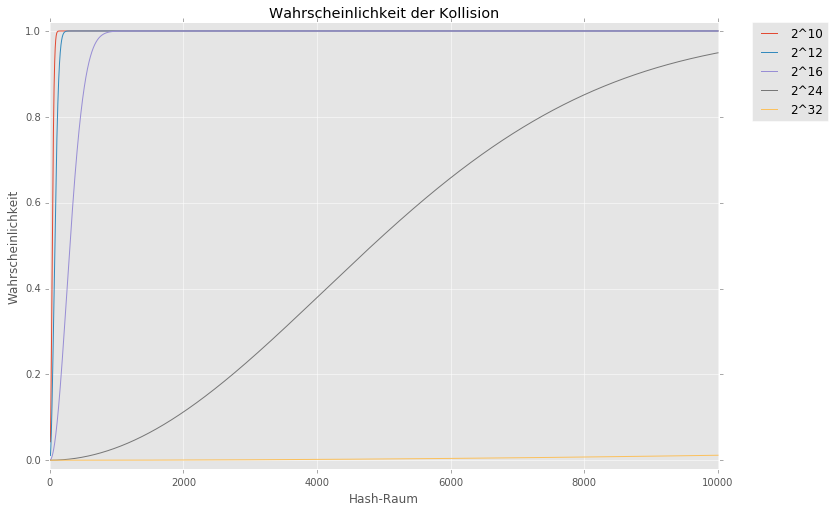

In [12]:
N = [2 ** n for n in (10, 12, 16, 24, 32)]

for n in N:
    x = list(range(10, 10001))
    
    # gleiches ergebnis bei verwendung von collision_probability_iter
    #y = [collision_probability_iter(i, n) for i in x]
    y = [collision_probability(i, n) for i in x]
    #plt.xscale('log')
    plt.plot(x, y, label='2^%d' % math.log2(n))

x_min, x_max, y_min, y_max = plt.axis()
plt.axis((x_min - 10, x_max + 10, y_min - .02, y_max + .02))

plt.title('Wahrscheinlichkeit der Kollision')
plt.xlabel('Hash-Raum')
plt.ylabel('Wahrscheinlichkeit')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Man kann sehen, dass bei einem Hashraum mit $N = 2^{24}$ und $10^4$ erzeugten Hashes die Wahrscheinlichkeit hoch ist eine Kollision zu erzeugen. Relativ sicher ist man erst bei einem Raum von $N = 2^{32}$.

In [13]:
print('{:%}'.format(collision_probability(10000, np.power(2, 32))))

1.157288%


### 5.2 Die händische Kordel

#### 5.2.1 Kollisionswahrscheinlichkeit von 50%

Wann ist bei einer unsicheren Hashfunktion die Wahrscheinlichkeit von 50% erreicht?

Hier wird wieder die Ausgangsformel verwendet.

$P = \large{1 - e^{\small{\dfrac{-k(k - 1)}{2N}}}}$ mit $P = 0.5$ und $N = 2^{32}$

----

$0.5 = \large{1 - e^{\small{\dfrac{-k(k - 1)}{2 * 2^{32}}}}}$

----

$log(0.5) = \small{\dfrac{-k(k - 1)}{2 * 2^{32}}}$

----

$k^2 - k = -log(0.5) * 2 * 2^{32}$

----

$k^2 - k + \frac{1}{4} = -log(0.5) * 2 * 2^{32} + \frac{1}{4}$

----

$(k - \frac{1}{2})^2 = -log(0.5) * 2 * 2^{32} + \frac{1}{4}$

----

$k - \frac{1}{2} = \sqrt{-log(0.5) * 2 * 2^{32} + \frac{1}{4}}$

----

$k = \sqrt{-log(0.5) * 2 * 2^{32} + \frac{1}{4}} + \frac{1}{2} = \large{77163,243}$

In [14]:
p = 0
i = 0
N = 2**32

while p <= .5:
    i += 1
    p = collision_probability(i, N)

print('Kontrollwert: %d' % i)

Kontrollwert: 77164


#### 5.2.2 Suche und Join

##### a) Zeichnung

Adressraum: 0 - 64

Peers:
(100124, 8)
(312017, 14)
(456123, 21)
(389412, 27)
(745831, 28)
(552891, 30)
(342978, 33)
(990737, 35)
(879498, 45)
(979999, 52)


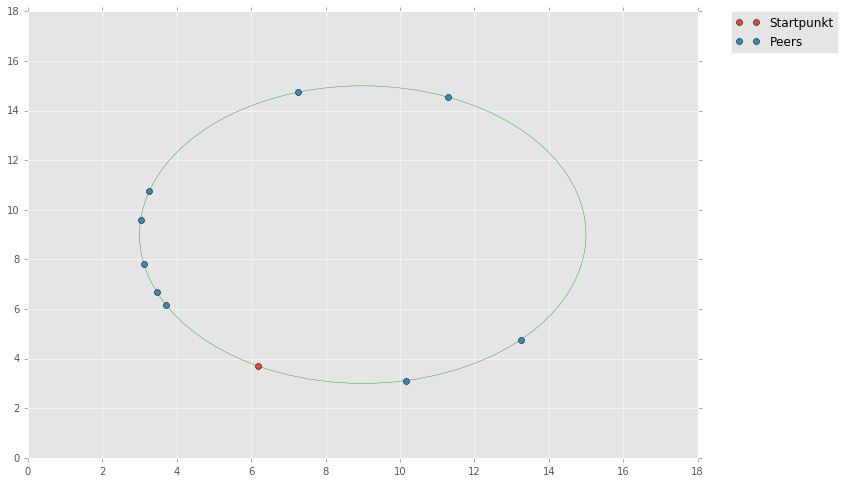

In [15]:
peer_addresses = (456123, 990737, 745831, 100124, 552891, 879498, 979999, 312017, 389412, 342978)
object_addresses = (481365992, 611723373)

N = 2**6
print('Adressraum: 0 - %d' % N)

def digit_sum(number):
    """Liefert die Quersumme der gegebenen Zahl.
    
    siehe `Wikipedia <https://de.wikipedia.org/wiki/Quersumme>`_ 
    """
    number = str(number)
    
    # 1. aufteilen des strings
    # 2. umwandlung jeder ziffer nach int
    # 3. summe berechnen
    return sum([int(number[i]) for i in range(len(number))])

peer_ids = [digit_sum(address) for address in peer_addresses]
peers = sorted(list(zip(peer_addresses, peer_ids)), key=lambda _id: _id[1])
print('\nPeers:')
for peer in peers:
    print(peer)

x_min = 0
x_max = 18
y_min = 0
y_max = 18

fig, ax = plt.subplots()
plt.axis([x_min, x_max, y_min, y_max])

circle_x = (x_max - x_min) / 2.
circle_y = (y_max - y_min) / 2.

radius = 6

# zeichnen eines kreises der den gesamten raum 0 <= n <= 2^6 angibt
circ = plt.Circle((circle_x, circle_y), radius=radius, color='#43a047', fill=False)
ax.add_patch(circ)

peer_coords = coords(peer_ids, N=N, radius=radius, x_trans=x_max / 2, y_trans=y_max / 2)

# startpunkt des rings
plt.plot(peer_coords[0][0], peer_coords[1][0], 'o', label='Startpunkt')

# plotten der peers
plt.plot(peer_coords[0][1:], peer_coords[1][1:], 'o', label='Peers')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

##### b) Suche nach Objekt

Der Knoten `(979999, 52)` sucht nach dem Objekt `(611723373, 33)`. Die theoretischen Finger des Knoten liegen bei

$id + 2^{i - 1}$

----

1. 53 = 52 + 1 % 64
2. 54 = 52 + 2 % 64
3. 56 = 52 + 4 % 64
4. 60 = 52 + 8 % 64
5. 4 = 52 + 16 % 64
6. 20 = 52 + 32 % 64

Theoretische Finger: [53, 54, 56, 60, 4, 20]


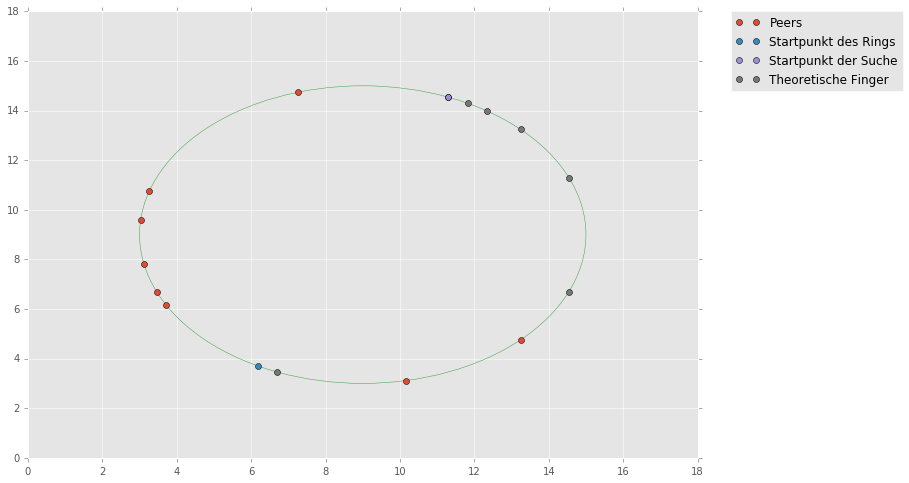

In [16]:
def theoretical_finger(peer_id, M=2**6):
    finger = []
    i = 1
    while i < M:
        finger.append((peer_id + i) % M)
        i = i * 2
    return finger
    
t_fingers = theoretical_finger(52)
print('Theoretische Finger: %s' % t_fingers)

fig, ax = plt.subplots()
plt.axis([x_min, x_max, y_min, y_max])

# zeichnen eines kreises der den gesamten raum 0 <= n <= 2^6 angibt
circ = plt.Circle((circle_x, circle_y), radius=radius, color='#43a047', fill=False)
ax.add_patch(circ)

# plotten der peers
plt.plot(peer_coords[0][1:], peer_coords[1][1:], 'o', label='Peers')

# startpunkt des rings
plt.plot(peer_coords[0][0], peer_coords[1][0], 'o', label='Startpunkt des Rings')

# startpunkt des suche
plt.plot(peer_coords[0][6], peer_coords[1][6], 'o', label='Startpunkt der Suche')

# plotten der finger
finger_coords = coords(t_fingers, N=N, radius=radius, x_trans=9, y_trans=9)
plt.plot(finger_coords[0], finger_coords[1], 'o', label='Theoretische Finger')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Eine gute Erklärung zu theoretischen und echten Fingern findet sich auch auf den Seiten des [Wiki der HU-Berlin](http://sarwiki.informatik.hu-berlin.de/Chord)

In [17]:
def next_real_finger(finger, N: set):
    N = sorted(list(N))
    candidates = [value for value in N if value >= finger]
    return candidates[0] if len(candidates) > 0 else N[0]

def finger_map(peer_id, peer_ids, M):
    """Liefert eine Menge an 2-Tupeln, die theoretische und reale Finger
    des Knotens mit der Id ``peer_id`` enthalten."""
    t_fingers = theoretical_finger(peer_id, M)
    r_fingers = [next_real_finger(f, peer_ids) for f in t_fingers]
    
    return list(zip(t_fingers, r_fingers))

def print_finger_table(table):
    print('{:<4s}{:>15s}{:>15s}'.format('#', 'theoretisch', 'real'))
    print(''.join(['-' for _ in range(34)]))
    for i in range(len(table)):
        t, r = table[i]
        print('{:<4d}{:>15d}{:>15}'.format(i + 1, t, r))
    

finger_table = finger_map(52, [p[1] for p in peers], M=2**6)
print_finger_table(finger_table)

#       theoretisch           real
----------------------------------
1                53              8
2                54              8
3                56              8
4                60              8
5                 4              8
6                20             21


Der Peer mit der Id `33` ist verantwortlich für das gesuchte Objekt.

Der Zuständigkeitsbereich des Knotens `8` ist `8 <= x < 21`. Somit ist er irrelevant für die Suche. Es wird somit der Knoten `21` gefragt. Dessen Zuständigkeitsbereich liegt zwischen `21 <= x < 27`. Er ist nicht für das Dokument zuständig, daher wird die Suche weitergeleitet.

In [18]:
finger_table = finger_map(21, [p[1] for p in peers], M=2**6)
print_finger_table(finger_table)

#       theoretisch           real
----------------------------------
1                22             27
2                23             27
3                25             27
4                29             30
5                37             45
6                53              8


Der nächst möglich zuständige Knoten ist Knoten `30`. Dessen Zuständigkeitsbereich liegt zwischen `30 <= x < 32`. Wie zuvor wird die Anfrage weitergegeben.

In [19]:
finger_table = finger_map(30, [p[1] for p in peers], M=2**6)
print_finger_table(finger_table)

#       theoretisch           real
----------------------------------
1                31             33
2                32             33
3                34             35
4                38             45
5                46             52
6                62              8


Knoten `30` kennt den Zielknoten `33`, der widerum das Dokument liefern kann. Es wurden 3 Hops (21, 30, 33) benötigt, um das Dokument zu finden.

##### c) Join

Wenn ein weiterer Knoten den Ring betreten will wird zunächst dessen Id ermittelt. Es wird davon ausgegangen, dass keine Kollision aufgetreten ist. 

1. Der Knoten wird an die entsprechende Stelle im Ring gesetzt
2. Der Vorgänger zum Knoten wird benachrichtigt

    2.1 Der Zuständigkeitsbereich wird angepasst

    2.2 Die Fingertabelle wird aktualisiert

3. Der Nachfolger wird benachrichtigt. Dieser Schritt erfolgt lediglich, wenn in der Fingertabelle der Vorgänger gespeichert wurd

### 5.3 Suche auf einem Chord-Ring

#### 5.3.1 Linear

In [20]:
import random

class ChordSearch:
    def __init__(self, peers:list, root_node:int, obj:int, M:int):
        self.peers = peers
        self.root_node = root_node
        self.obj = obj
        self.M = M
        
    def next_node(self, peer):
        position = self.peers.index(peer)
        return self.peers[position + 1] if self.peers[-1] != peer else self.peers[0]

    def is_responsible(self, peer, object_id=None):
        
        if not object_id:
            object_id = self.obj
        
        successor = self.next_node(peer)
        start, end = peer, successor - 1
        if end < start:
            return start <= object_id <= M or 0 <= object_id <= end
        else:
            return start <= object_id <= end
        
    def search(self, root_node=None, obj=None):
        print('no search method implemented in %s' % self.__name__)
        return None

In [21]:
class LinearChordSearch(ChordSearch):

    def search(self, root_node=None, obj=None):
        
        peer = root_node if root_node else self.root_node
        obj = obj if obj else self.obj
        
        hops = 0
        while not self.is_responsible(peer, obj):
            peer = self.next_node(peer)
            hops += 1
        return (peer, hops)

In [22]:
# Testlauf zur Pruefung

def run_search(search: ChordSearch):
    peer, hops = search.search()
    print('root: %4d - object: %4d - responsible: %4d - hops: %d' 
          % (search.root_node, search.obj, peer, hops))

M = 2**4
peers = [1, 4, 8, 9]

run_search(LinearChordSearch(peers, 4, 5, M))
run_search(LinearChordSearch(peers, 4, 8, M))
run_search(LinearChordSearch(peers, 8, 11, M))
run_search(LinearChordSearch(peers, 8, 1, M))
run_search(LinearChordSearch(peers, 8, 0, M))
run_search(LinearChordSearch(peers, 8, 7, M))
run_search(LinearChordSearch(peers, 8, 8, M))

root:    4 - object:    5 - responsible:    4 - hops: 0
root:    4 - object:    8 - responsible:    8 - hops: 1
root:    8 - object:   11 - responsible:    9 - hops: 1
root:    8 - object:    1 - responsible:    1 - hops: 2
root:    8 - object:    0 - responsible:    9 - hops: 1
root:    8 - object:    7 - responsible:    4 - hops: 3
root:    8 - object:    8 - responsible:    8 - hops: 0


In [23]:
from datetime import datetime

M = 2**32
peer_count = 2**13
peers = sorted([random.randint(0, M) for _ in range(peer_count)])
search_base = random.choice(peers)
object_id = random.randint(0, M)
print('Ersten Peers')
print('------------')
print('\n'.join([str(p) for p in peers[:10]]))
print()

time = datetime.now()
run_search(LinearChordSearch(peers, search_base, object_id, M))
print('Suchzeit: %s' % str(datetime.now() - time))

Ersten Peers
------------
2455622
3962686
4582575
4631074
4747702
5789853
6573676
6599886
6713869
7639824

root: 2061266639 - object: 3508487442 - responsible: 3508055363 - hops: 2719
Suchzeit: 0:00:00.406183


### 5.3.2

Als Ausgangspunkt für die Suchen werden eine unterschiedliche Anzahl Knoten $N$ aus dem Hashraum $M$ generiert, so dass erkannt werden kann, wie viele Hops bzw. wie viel Zeit nötigt wird um ein Suchergebnis zu ermitteln.

In [24]:
from datetime import datetime

objects = []

with open('exercise5_names.txt', mode='r') as names:
    for _ in range(100):
        objects.append(names.readline().strip())
    
    objects = [(djb2(name), name) for name in objects]
    
# Adressraum
M = 2**32

# Anzahl der Knoten pro Suche
N = (2**4, 2**8, 2**10, 2**11, 2**12, 2**13, 2**14)

# Zufaellig generierte Knoten
peers = [sorted(random.sample(range(M), n)) for n in N]

Suche in Knotenmenge 2^4
Suche in Knotenmenge 2^8
Suche in Knotenmenge 2^10
Suche in Knotenmenge 2^11
Suche in Knotenmenge 2^12
Suche in Knotenmenge 2^13
Suche in Knotenmenge 2^14
..fertig


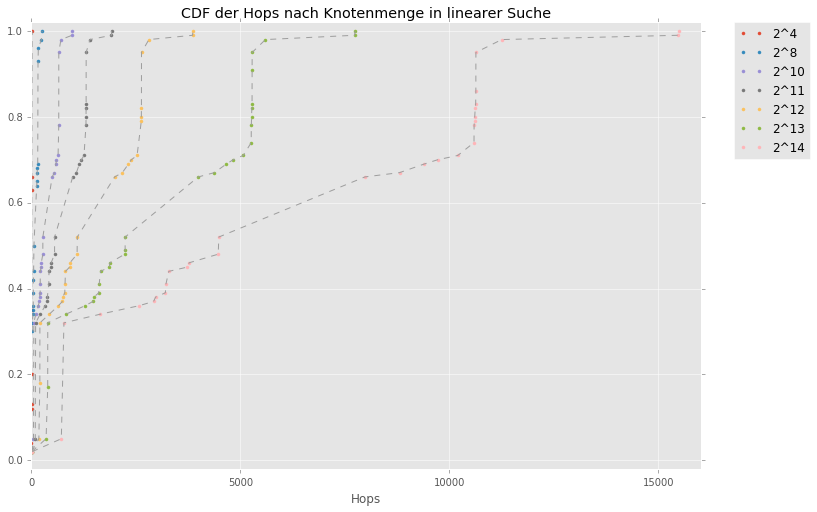

In [25]:
hops = [[] for _ in range(len(N))]
search_times = [{'count': c, 'times': []} for c in N]

for i in range(len(N)):
    i_peers = peers[i]
    search_base = i_peers[0]
    
    print('Suche in Knotenmenge 2^%d' % np.log2(N[i]))
    
    for _hash, obj in objects:
        time = datetime.now()
        search = LinearChordSearch(i_peers, search_base, _hash, M)
        peer, num_hops = search.search()
        search_times[i]['times'].append(datetime.now() - time)
        hops[i].append(num_hops)
        
print('..fertig')

for i in range(len(hops)):
    x, y = ecdf(hops[i])
    plt.plot(x, y, linestyle=' ', marker='.', label='2^%d' % np.log2(N[i]))
    plt.plot(x, y, '--', color='#9e9e9e')

x_min, x_max, y_min, y_max = plt.axis()
plt.axis((x_min - 10, x_max + 10, y_min - .02, y_max + .02))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('CDF der Hops nach Knotenmenge in linearer Suche')
plt.xlabel('Hops')
plt.show()

Man kann sehen, dass je mehr Knoten sich im Ring befinden, die Anzahl der Hops sehr schnell nach oben geht. Bei einer Anzahl >= $2^{12}$ (4096) dauert die Suche zudem extrem lange. Eine lineare Suche macht also nur Sinn, wenn der Ring zu 0.0001 % besetzt ist.

Suchzeit
--------

Menge   Min      Max   Mean    Median
2^4     0.00001  0.00  0.0000  0.00002
2^8     0.00002  0.00  0.0003  0.00027
2^10    0.00001  0.01  0.0032  0.00140
2^11    0.00001  0.05  0.0115  0.00498
2^12    0.00001  0.21  0.0455  0.01890
2^13    0.00002  0.87  0.1866  0.07580
2^14    0.00003  3.64  0.7821  0.31898


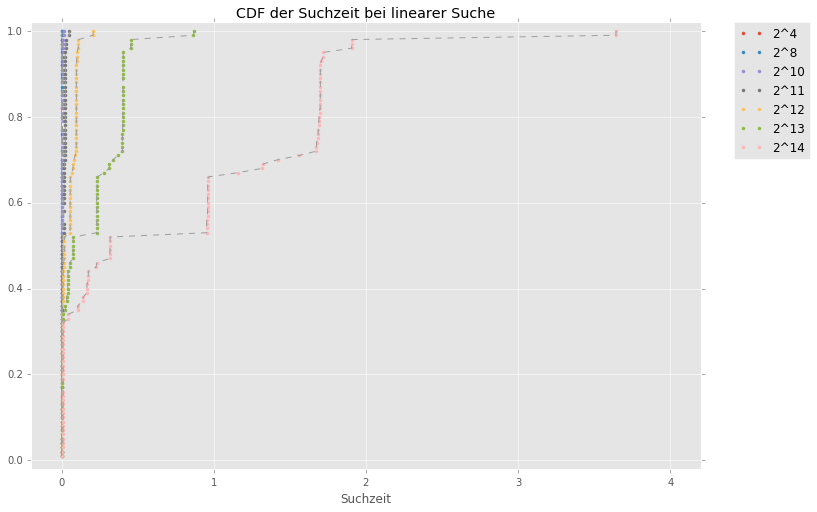

In [26]:
def print_search_time_stats(search_times):
    
    print('Suchzeit')
    print('--------', end='\n\n')
    print('Menge   Min      Max   Mean    Median')
    
    for data in search_times:
        times = [t.total_seconds() for t in data['times']]
        mean = np.mean(times)
        median = np.median(times)
        min_time = min(times)
        max_time = max(times)
        fmt = '2^{:<4d}  {:<.5f}  {:<.2f}  {:<.4f}  {:<.5f}'
        print(fmt.format(int(np.log2(data['count'])), 
                         min_time,
                         max_time,
                         mean,
                         median))

print_search_time_stats(search_times)        

for data in search_times:
    times = [t.total_seconds() for t in data['times']]
    
    x, y = ecdf(times)
    plt.plot(x, y, linestyle=' ', marker='.', label='2^%d' % np.log2(data['count']))
    plt.plot(x, y, '--', color='#9e9e9e')

x_min, x_max, y_min, y_max = plt.axis()
plt.axis((x_min - .2, x_max + .2, y_min - .02, y_max + .02))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('CDF der Suchzeit bei linearer Suche')
plt.xlabel('Suchzeit')
plt.show()

#### 5.3.3 Erweiterung auf Fingertabelle

In [27]:
class FingerChordSearch(ChordSearch):
    
    def search(self, root_node=None, obj=None):
        
        peer = root_node if root_node else self.root_node
        obj = obj if obj else self.obj
        hops = 0
        while not self.is_responsible(peer, obj):
            # sortierte menge der einzigartigen realen nachfolger
            fingers = sorted(set([f[1] for f in finger_map(peer, self.peers, self.M)]))
            
            # der naechste anzusprechende knoten ist der knoten mit 
            # id <= object_id < nachfolger id
            next_peer = None
            i = 0
            while i < len(fingers):
                finger = fingers[i]
                if finger <= obj:
                    next_peer = finger
                i += 1
            if not next_peer:
                next_peer = fingers[-1]
            peer = next_peer
            hops += 1
        return (peer, hops)

#### 5.3.4 Vergleich Linear - Finger

Suche in Knotenmenge 2^4
Suche in Knotenmenge 2^8
Suche in Knotenmenge 2^10
Suche in Knotenmenge 2^11
Suche in Knotenmenge 2^12
Suche in Knotenmenge 2^13
Suche in Knotenmenge 2^14
..fertig


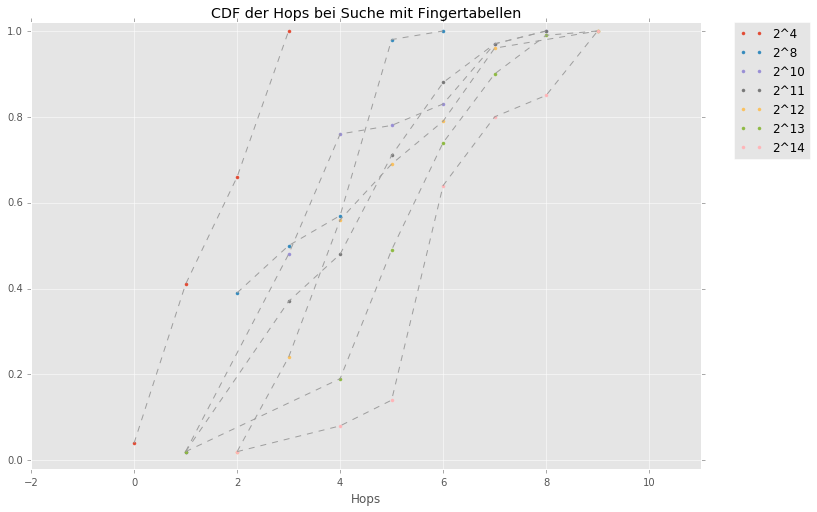

In [28]:
N2 = (2**15,)
peers = peers + [sorted(random.sample(range(M), n)) for n in N2]

hops = [[] for _ in range(len(N))]
search_times = [{'count': c, 'times': []} for c in N]

for i in range(len(N)):
    i_peers = peers[i]
    search_base = i_peers[0]
    
    print('Suche in Knotenmenge 2^%d' % np.log2(N[i]))
    
    for _hash, obj in objects:
        time = datetime.now()
        search = FingerChordSearch(i_peers, search_base, _hash, M)
        peer, num_hops = search.search()
        search_times[i]['times'].append(datetime.now() - time)
        hops[i].append(num_hops)
        
print('..fertig')

for i in range(len(hops)):
    x, y = ecdf(hops[i])
    plt.plot(x, y, linestyle=' ', marker='.', label='2^%d' % np.log2(N[i]))
    plt.plot(x, y, '--', color='#9e9e9e')

x_min, x_max, y_min, y_max = plt.axis()
plt.axis((x_min - 2, x_max + 2, y_min - .02, y_max + .02))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('CDF der Hops bei Suche mit Fingertabellen')
plt.xlabel('Hops')
plt.show()

Suchzeit
--------

Menge   Min      Max   Mean    Median
2^4     0.00001  0.00  0.0002  0.00019
2^8     0.00118  0.00  0.0021  0.00207
2^10    0.00225  0.02  0.0091  0.00835
2^11    0.00457  0.03  0.0197  0.02086
2^12    0.01874  0.08  0.0425  0.03728
2^13    0.01937  0.15  0.1036  0.10431
2^14    0.08177  0.36  0.2542  0.24891


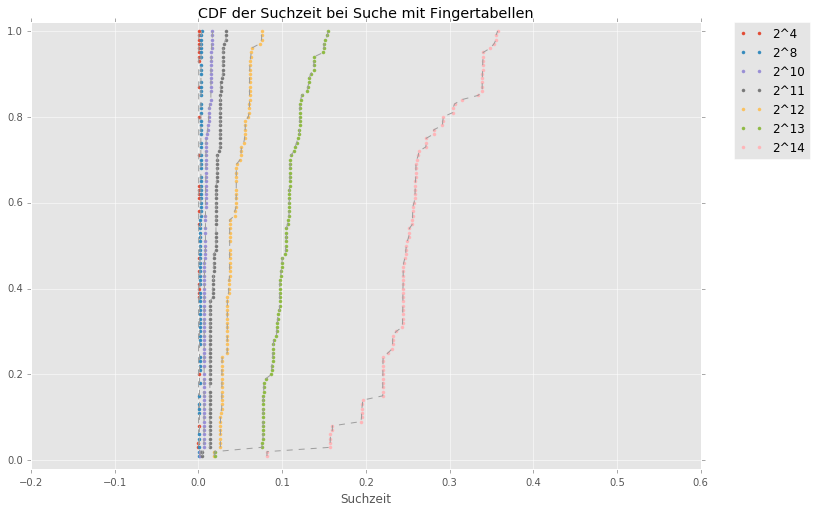

In [29]:
print_search_time_stats(search_times)
for time in search_times:
    times = [t.total_seconds() for t in time['times']]
    
    x, y = ecdf(times)
    plt.plot(x, y, linestyle=' ', marker='.', label='2^%d' % np.log2(time['count']))
    plt.plot(x, y, '--', color='#9e9e9e')

x_min, x_max, y_min, y_max = plt.axis()
plt.axis((x_min - .2, x_max + .2, y_min - .02, y_max + .02))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('CDF der Suchzeit bei Suche mit Fingertabellen')
plt.xlabel('Suchzeit')
plt.show()

Auf den ersten Blick sieht die Suchzeit bei der Verwendung von Fingertabellen schlechter aus, als die lineare Suche. Allerdings kann man feststellen, dass die Anzahl an erforderlichen Hops bis zum Fund eines Ergebnisses niedriger ist. Wenn man nun bedenkt, dass die Knoten über das Internet verteilt sind und ein Anfrage mit entsprechender Antwort lange dauert ist der Ansatz über Fingertabellen zu bevorzugen. Zudem ist ab einer bestimmten Anzahl Peers die Suche bereits in der Beispielimplementierung schneller als die lineare Suche.